In [10]:
#computation
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy import stats
import statsmodels.api as sm

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

#modelling
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, f1_score
from sklearn.calibration  import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest

In [11]:
#read the data
df = pd.read_csv('training_set.csv')
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X49,X50,X51,X52,X53,X54,X55,X56,X57,Y
0,0,0.00,0.00,4.34,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.000,0.0,1.342,0.000,0.000,1.200,2,12,0
1,1,0.00,0.56,0.56,0.00,1.12,0.56,2.25,0.00,0.0,...,0.0,0.083,0.0,0.503,0.000,0.083,16.304,148,375,1
2,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.000,0.0,0.000,0.000,0.000,1.000,1,5,0
3,3,0.64,0.00,0.64,0.00,1.93,0.00,0.00,0.00,0.0,...,0.0,0.000,0.0,0.462,0.370,0.000,2.440,22,122,1
4,4,0.58,0.00,0.00,35.46,0.58,0.00,0.58,0.58,0.0,...,0.0,0.000,0.0,0.239,0.239,0.000,3.338,123,207,1


In [12]:
#independent variables
features = df.columns[1:58]
#dependent variable/class labels
class_label = df['Y']

<h2>Feature selection using chi2 test</h2>

In [72]:
#select top features using chi2 test
select_kbest = SelectKBest(score_func=chi2)
#fit the data
most_imp_bigram = select_kbest.fit(df[features], class_label)
#get feature names of top selected features
selected_features = select_kbest.get_feature_names_out()
df_final = df[list(selected_features)]
df_final.head()

,X7,X16,X19,X21,X25,X26,X27,X55,X56,X57
0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,1.200,2,12
1,2.25,0.00,3.38,1.12,0.0,0.0,0.0,16.304,148,375
2,0.00,0.00,8.10,0.00,0.0,0.0,0.0,1.000,1,5
3,0.00,1.29,1.93,2.58,0.0,0.0,0.0,2.440,22,122
4,0.58,0.58,0.58,1.74,0.0,0.0,0.0,3.338,123,207


In [73]:
#since the data is right skewed hence applying log transform to selected features 
for i in list(selected_features):
    df_final[i]  = np.log(df_final[i]+1e-3)

<ipython-input-73-5518bc454034>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[i]  = np.log(df_final[i]+1e-3)


In [74]:
#split the data into train and validation data
X = df_final
Y = class_label
X_train, X_val, y_train, y_val =  train_test_split(X, Y, test_size = 0.2, random_state = 20)

<h1>Modelling</h1>

<h2>Logistic Regression</h2>

- with features selected using chi2 test

In [75]:
lr = LogisticRegression(C=100, class_weight = 'balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced')

training accuracy - 0.8887468030690537,  val accuracy - 0.887468030690537
training f1 - 0.8632075471698114,  val f1 - 0.8450704225352113
training log loss - 0.2647180393535035, val log loss - 0.2621334551786169


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


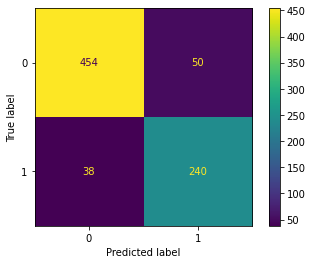

In [76]:
y_pred_tr = lr.predict(X_train)
y_pred = lr.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = lr.predict_proba(X_train)
y_pred_proba = lr.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(lr, X_val, y_val)  
plt.show()

<h2>SVM</h2>

- with  features selected using chi2 test

In [77]:
#polynomial kernel with degree 3 performed the best among all the kernels including linear and rbf
svm = SVC(kernel = 'poly', degree = 3, class_weight = 'balanced', probability=True)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='poly', probability=True)

training accuracy - 0.8868286445012787,  val accuracy - 0.8925831202046036
training f1 - 0.8608490566037735,  val f1 - 0.85
training log loss - 0.258191656355126, val log loss - 0.25579109339179973


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


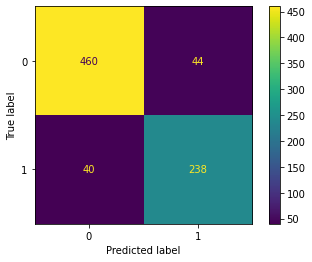

In [78]:
y_pred_tr = svm.predict(X_train)
y_pred = svm.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = svm.predict_proba(X_train)
y_pred_proba = svm.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(svm, X_val, y_val)  
plt.show()

In [79]:
# pip install --upgrade xgboost==0.22.2

<h3>XGBOOST</h3>

In [80]:
xg_cf=XGBClassifier()
xg_cf.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(xg_cf, method='sigmoid')
c_cfl.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None, gamma=0,
                                                    gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                              

training accuracy - 0.9942455242966752,  val accuracy - 0.9373401534526854
training f1 - 0.9927884615384615,  val f1 - 0.912655971479501
training log loss - 0.08205842520952496, val log loss - 0.19453738484638983


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


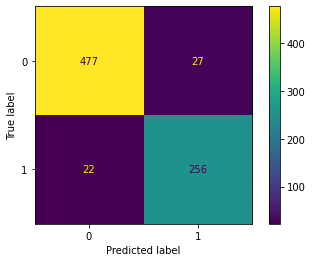

In [81]:
xg_cf=XGBClassifier()
xg_cf.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(xg_cf, method='sigmoid')
c_cfl.fit(X_train, y_train)

y_pred_tr = xg_cf.predict(X_train)
y_pred = xg_cf.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = c_cfl.predict_proba(X_train)
y_pred_proba = c_cfl.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(xg_cf, X_val, y_val)  
plt.show()

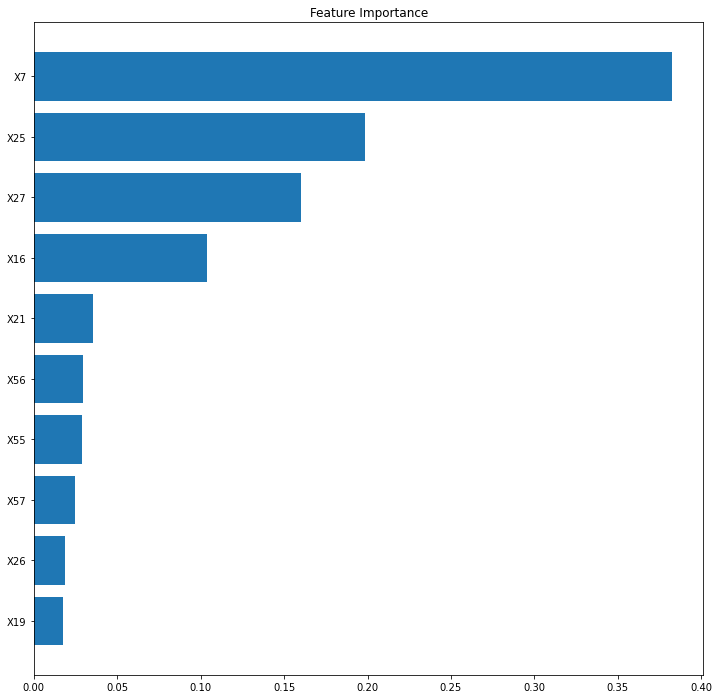

In [82]:
plot_feature_importances(xg_cf)

<h2>Feature selection using forward feature selection</h2>

In [13]:
from sklearn.calibration  import CalibratedClassifierCV

In [14]:
clf = Ridge(alpha=1.0)
sfs_forward = SequentialFeatureSelector(
    clf, n_features_to_select=0.6, direction="forward").fit(df[features], df['Y'])

#get top selected features  
sfs_forward.get_feature_names_out()
df_final = df[list(sfs_forward.get_feature_names_out())]

In [15]:
#since the data is right swewed hence applying log transform to selected features
for i in sfs_forward.get_feature_names_out():
    df_final[i]  = np.log(df_final[i]+1e-3)

<ipython-input-15-1b0dcb43bf6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[i]  = np.log(df_final[i]+1e-3)


In [16]:
df_final.head()

,X3,X4,X5,X6,X7,X8,X9,X12,X16,X17,...,X43,X44,X45,X46,X47,X48,X49,X52,X53,X57
0,1.468105,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.294906,-6.907755,2.484990
1,-0.578034,-6.907755,0.114221,-0.578034,0.811375,-6.907755,-6.907755,-0.578034,-6.907755,-6.907755,...,-6.907755,-6.907755,-0.578034,-6.907755,-6.907755,-6.907755,-6.907755,-0.685179,-6.907755,5.926929
2,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,0.993622,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,1.609638
3,-0.444726,-6.907755,0.658038,-6.907755,-6.907755,-6.907755,-6.907755,0.255417,0.255417,-0.444726,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-0.770028,-0.991553,4.804029
4,-6.907755,3.568434,-0.543005,-6.907755,-0.543005,-0.543005,-6.907755,-6.907755,-0.543005,-0.543005,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-1.427116,-1.427116,5.332724


In [17]:
df_final.columns

Index(['X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X12', 'X16', 'X17', 'X18',
       'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X33',
       'X35', 'X37', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49',
       'X52', 'X53', 'X57'],
      dtype='object')

In [18]:
#split the data into train and validation data
X = df_final
Y = df['Y']
X_train, X_val, y_train, y_val =  train_test_split(X, Y, test_size = 0.2, random_state = 20)

<h1>Modelling</h1>

<h2>Logistic Regression</h2>

- with features selected using forward feature selection method

In [88]:
lr = LogisticRegression(C =100, class_weight = 'balanced')
lr.fit(X_train, y_train)

C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100, class_weight='balanced')

training accuracy - 0.9427749360613811,  val accuracy - 0.9360613810741688
training f1 - 0.9292769656262347,  val f1 - 0.9100719424460432
training log loss - 0.16159531054746207, val log loss - 0.18968650539788315


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


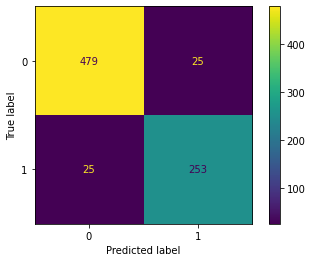

In [89]:
y_pred_tr = lr.predict(X_train)
y_pred = lr.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = lr.predict_proba(X_train)
y_pred_proba = lr.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(lr, X_val, y_val)  
plt.show()

<h2>SVM</h2>

- with features selected using forward feature selection method

In [19]:
from sklearn.svm import SVC
svm = SVC(class_weight = 'balanced', probability=True)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

training accuracy - 0.953005115089514,  val accuracy - 0.9475703324808185
training f1 - 0.9417821782178218,  val f1 - 0.926654740608229
training log loss - 0.12711380960896612, val log loss - 0.15693402424536118


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


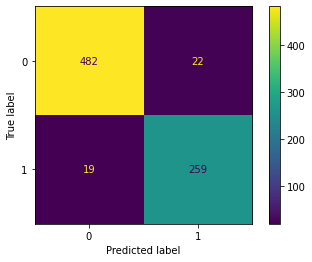

In [20]:
#rbf outperformed polynomial and linear kernel
y_pred_tr = svm.predict(X_train)
y_pred = svm.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = svm.predict_proba(X_train)
y_pred_proba = svm.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(svm, X_val, y_val)  
plt.show()

In [22]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(svm, open(filename, 'wb'))

<h3>XGBOOST</h3>

training accuracy - 0.995843989769821,  val accuracy - 0.9462915601023018
training f1 - 0.9948020791683326,  val f1 - 0.924187725631769
training log loss - 0.05189355690241793, val log loss - 0.1574845265232112


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


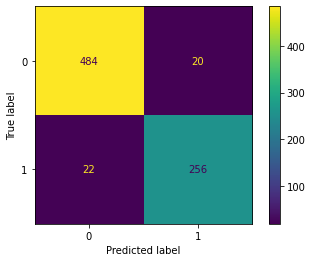

In [93]:
xg_cf=XGBClassifier()
xg_cf.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(xg_cf, method='sigmoid')
c_cfl.fit(X_train, y_train)

y_pred_tr = xg_cf.predict(X_train)
y_pred = xg_cf.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = c_cfl.predict_proba(X_train)
y_pred_proba = c_cfl.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(xg_cf, X_val, y_val)  
plt.show()

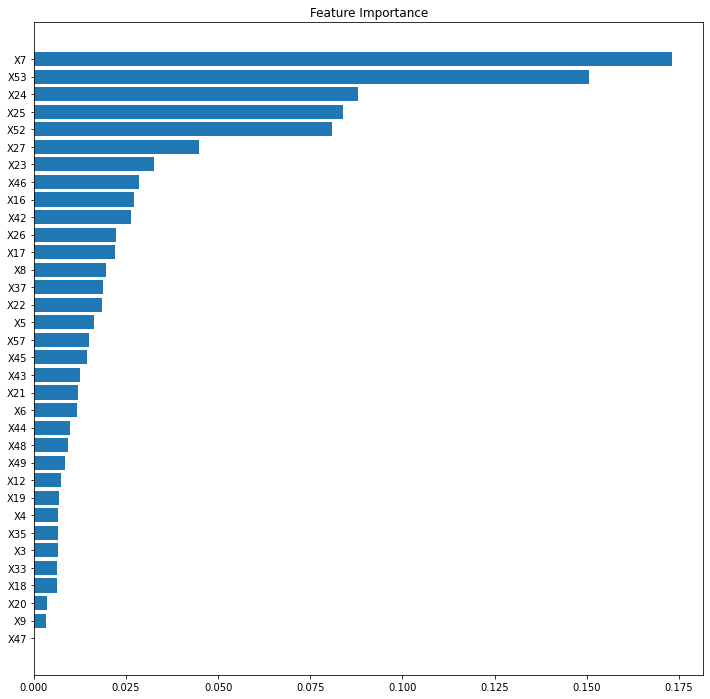

In [94]:
#plotting feature importance
plot_feature_importances(xg_cf)

<h2>Using All Features</h2>

In [95]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV 
#split the data into train and validation data
X = df[features]
Y = df['Y']
X_train, X_val, y_train, y_val =  train_test_split(X, Y, test_size = 0.2, random_state = 20)

<h2>Logistic Regression</h2>

In [96]:
lr = LogisticRegression(C =100, class_weight = 'balanced')
lr.fit(X_train, y_train)

C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100, class_weight='balanced')

training accuracy - 0.9213554987212276,  val accuracy - 0.9168797953964194
training f1 - 0.9042056074766355,  val f1 - 0.8853615520282188
training log loss - 0.23354346960164465, val log loss - 0.29078954826084136


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


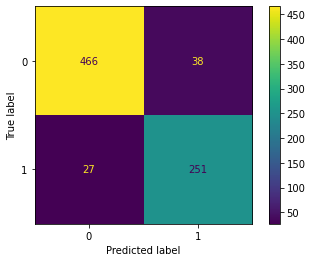

In [97]:
y_pred_tr = lr.predict(X_train)
y_pred = lr.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = lr.predict_proba(X_train)
y_pred_proba = lr.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(lr, X_val, y_val)  
plt.show()

<h2>SVM</h2>

In [98]:
svm = SVC(class_weight = 'balanced', probability=True)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

training accuracy - 0.6978900255754475,  val accuracy - 0.7263427109974424
training f1 - 0.6286836935166994,  val f1 - 0.627177700348432
training log loss - 0.5536457967072866, val log loss - 0.5282568799432283


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


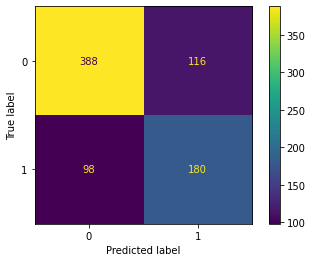

In [99]:
y_pred_tr = svm.predict(X_train)
y_pred = svm.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = svm.predict_proba(X_train)
y_pred_proba = svm.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(svm, X_val, y_val)  
plt.show()

<h2>XGBOOST</h2>

- with all the features

training accuracy - 0.9990409207161125,  val accuracy - 0.9526854219948849
training f1 - 0.998805256869773,  val f1 - 0.9326047358834243
training log loss - 0.04490695455245478, val log loss - 0.1423758771017


C:\Users\siddh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


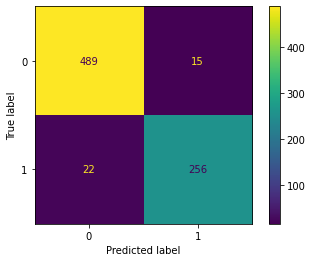

In [101]:
xg_cf=XGBClassifier()
xg_cf.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(xg_cf, method='sigmoid')
c_cfl.fit(X_train, y_train)

y_pred_tr = xg_cf.predict(X_train)
y_pred = xg_cf.predict(X_val)
print("training accuracy - {},  val accuracy - {}".format(accuracy_score(y_train, y_pred_tr), accuracy_score(y_val, y_pred)))
print("training f1 - {},  val f1 - {}".format(f1_score(y_train, y_pred_tr), f1_score(y_val, y_pred)))
y_pred_proba_tr = c_cfl.predict_proba(X_train)
y_pred_proba = c_cfl.predict_proba(X_val)
print("training log loss - {}, val log loss - {}".format(log_loss(y_train, y_pred_proba_tr), log_loss(y_val, y_pred_proba)))
plot_confusion_matrix(xg_cf, X_val, y_val)  
plt.show()

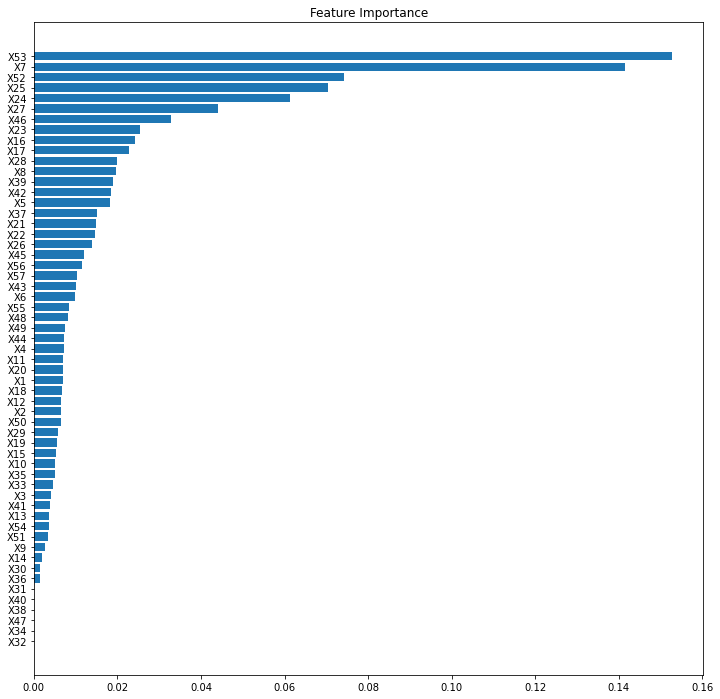

In [102]:
#plotting feature importance
plot_feature_importances(xg_cf)

<h2>Summary</h2>

In [23]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Feature_selection_technique", "Model", "Val_Accuracy", "Val_F1_score", "Val_log_loss"])
  
# Add rows
myTable.add_row(["Chi2", "Logistic Regression", "0.8874", "0.8450", "0.2621"])
myTable.add_row(["Chi2", "SVM", "0.8925", "0.85", "0.2558"])
myTable.add_row(["Chi2", "Xgboost", "0.9156", "0.8846", "0.1945"])
myTable.add_row(["Forward Feature Selection", "Logistic Regression", "0.9360", "0.9100", "0.1896"])
myTable.add_row(["Forward Feature Selection", "SVM", "0.9475", "0.9266", "0.1569"])
myTable.add_row(["Forward Feature Selection", "Xgboost", "0.9437", "0.9191", "0.1574"])
myTable.add_row(["All features", "Logistic Regression", "0.9168", "0.8853", "0.2907"])
myTable.add_row(["All features", "SVM", "0.7263", "0.6271", "0.5283"])
myTable.add_row(["All features", "Xgboost", "0.9526", "0.9326", "0.1423"])
  
print(myTable)

+-----------------------------+---------------------+--------------+--------------+--------------+
| Feature_selection_technique |        Model        | Val_Accuracy | Val_F1_score | Val_log_loss |
+-----------------------------+---------------------+--------------+--------------+--------------+
|             Chi2            | Logistic Regression |    0.8874    |    0.8450    |    0.2621    |
|             Chi2            |         SVM         |    0.8925    |     0.85     |    0.2558    |
|             Chi2            |       Xgboost       |    0.9156    |    0.8846    |    0.1945    |
|  Forward Feature Selection  | Logistic Regression |    0.9360    |    0.9100    |    0.1896    |
|  Forward Feature Selection  |         SVM         |    0.9475    |    0.9266    |    0.1569    |
|  Forward Feature Selection  |       Xgboost       |    0.9437    |    0.9191    |    0.1574    |
|         All features        | Logistic Regression |    0.9168    |    0.8853    |    0.2907    |
|         

- Final model would be svm with features obtained using forward feature selection method

- Justifications for svm performing well and choosing it for final modelling
  
- Data might not be linearly seperable and hence logistic regression or svm with linear kernel are not performing as
  good as non linear models like xgboost or svm with rbf or polynomial kernel.
  
- Due to addition of more features in forward feature selection then chi2 the performance of linear models improved because they   have higher number of dimensions(possibilites) to draw a hyperplane that can best seperate the two classes.

- SVM with polynomial kernel is chosen as the final model because it was performing the best(highest accuracy/f1_score).Also the training time is less for it then xgboost model. Hence svm was selected as the final model. Also the difference between training and test accuracies is less in case of svm in comparasion to xgboost which shows the the model generalizes well for both seen and unseen data.